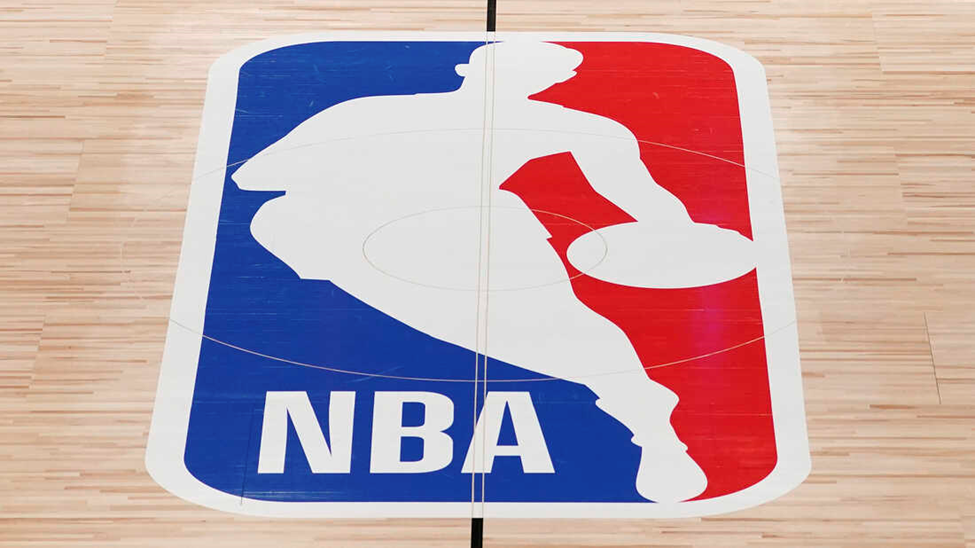

# NBA PLAYOFF PERFORMANCE PREDICTOR

Author: Ziyuan Wang

## Overview


Basketball is one of the most popular sports around the world. NBA, national basketball assosiation, is the most popular basketball league where best basketball players from different countries cahsing the the champaionships. 

For this project, the goal is trying to predict playoff performance based on stats from regular season. The regular season stats are team stats and collected from last 20 years. For the stakeholder, it will be general managers from all 30 teams. No matter how good your team play, this predictor is very usrful since you can use it to make better decision for team development. More deatils would be cover in Business problem part.

For data, after figuring out the exact meaning for each column, I drop those columns which were obviously not related to our target. Then it's about modeling: I built some baseline models with default hyperparameters on different classifier. Then I tried different hyperparameters to get the best model with best data accurancy, recall, f1 score, which means have a better chance to identify where the team would be ended up in that season.

Accuracy for the final model 15% higher than Baseline dummy model and around 65% which looked not that good. But considering the high uncertainty for basketball, it is a pretty descent result.



## Business Problem

For NBA team general managers, their job is to make money and let the team go as far as they can. By implement my predictor, the manger will have a higher chance to see how far this team could go for the season. For example, If they found out the team had very few chance to win the title or even few chance to make the playoff, the team can make decision to play young players more and earn more expirence.In this way, the team will have a better chance to have a better record in the future. On the other hand, if the predictor predict the team have a very high chance to go far in the playoffs. The genral manager could make some trades or obation some vetran players from the buyout market to make the team better. 

This predictor would be very useful for team to make mid-season decisions as well as teams whose standing is from 5 to 13 in each conference. 

## Data Understanding


In [2]:
import numpy as np
import pandas as pd

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression,\
LassoCV, RidgeCV, ElasticNetCV, LogisticRegression

from sklearn.model_selection import train_test_split, cross_validate, KFold, \
cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, \
FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, \
plot_confusion_matrix,  precision_score, recall_score, accuracy_score, f1_score, \
log_loss, roc_curve, roc_auc_score, classification_report, plot_roc_curve

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.multiclass import OneVsRestClassifier

method

Then after I merged average stats with advanced stats on Team column, there are totally 45 different features. Now we can spend more time take more close look about then one by one since not all of the columns will affect win result:

GP=Total games each team play for the season. Same for every team. (Will drop this column before modeling.)

MPG=Average minutes play per game. The standard MPG would be 48.0 but some of them could be fourty eight point something since there would be overtime for some games. (Will drop this column before modeling.)

PPG=Point per game.Reflect the ability to score the basket.

FGM= Feild goals made per game.

FGA= Feild goals attempts per game.

FG%= Average Feild goals percantage per game.

3PM= 3point Feild goals made per game.

3PA= 3point Feild goals attempts per game.

3P%= 3point Feild goals percantage per game.

FTM= Free throw made per game.

FTA= Free throw attempts per game.

FT%= Free throw percantage per game.

ORB= Offensive Rebound per game

DRB= Denfensive Rebound per game

RPG= Total Rebound per game

APG= Assists per game

SPG= steals per game

BPG= Blocks per game

TOV= Total turnovers per game

PF= Fouls per game

Win= Total games won

Loss= Total games lost

Win%= Win percantage

HG= Total home games

HGW= Total home game won

HGW%= Home game win percantage

Attendance= Average attendance per game

In [8]:
df2001_ave = pd.read_csv('./Data/2001_2021_average.csv')

In [9]:
df2001_ave.head()

Team   G     MP    FG   FGA    FG%    3P   3PA    3P%    2P  \
0     Atlanta Hawks*  82  240.3  41.5  88.3  0.470  12.9  34.4  0.374  28.6   
1    Boston Celtics*  82  242.7  40.7  87.4  0.466  13.2  37.1  0.356  27.5   
2     Brooklyn Nets*  82  240.9  42.0  88.4  0.475  11.5  31.7  0.361  30.5   
3  Charlotte Hornets  82  242.4  42.8  91.4  0.468  13.9  38.2  0.365  28.8   
4     Chicago Bulls*  82  240.6  41.7  86.9  0.480  10.6  28.8  0.369  31.1   

   ...  TOV%  ORB%  FT/FGA  OeFG%  OTOV%  ODRB%  OFT/FGA             Arena  \
0  ...  10.8  23.0   0.205  0.543   11.5   76.9    0.177  State Farm Arena   
1  ...  12.4  24.0   0.195  0.502   12.5   77.3    0.183         TD Garden   
2  ...  12.5  23.9   0.198  0.521   11.7   75.1    0.201   Barclays Center   
3  ...  11.6  23.3   0.173  0.544   13.1   74.8    0.187   Spectrum Center   
4  ...  11.8  20.4   0.201  0.541   11.9   78.3    0.199     United Center   

   Attend.  Attend./G  
0  672,742     16,408  
1  785,396     19,156  
2  711,539     17,355  
3  700,755     17,092  
4  856,148     20,882  

[5 rows x 73 columns]

The Result column here: They are inputed mannully one by one from https://www.landofbasketball.com/. The result column will be my target for modeling and it will consist of 6 types of result(0 through 5). More explaination: 0 means the team didn't made the playoffs, 1 means the team lost in the first round of the playoffs, 2 means the team lost in the second round of the playoffs, 3 means the team lost in the third round of the playoffs, 4 means the team lost in the Final and 5 means the team won the champ.

The results were inputed mannully and to save time, I didn't input anything for teams didn't make the playoffs. So here we have add a step to relpace every nan to 0 for result column

In [10]:
#replace nan to zero for reslut column
df2001_ave['Result'] = df2001_ave['Result'].fillna(0)

In [11]:
df2001_ave.head()

Team   G     MP    FG   FGA    FG%    3P   3PA    3P%    2P  \
0     Atlanta Hawks*  82  240.3  41.5  88.3  0.470  12.9  34.4  0.374  28.6   
1    Boston Celtics*  82  242.7  40.7  87.4  0.466  13.2  37.1  0.356  27.5   
2     Brooklyn Nets*  82  240.9  42.0  88.4  0.475  11.5  31.7  0.361  30.5   
3  Charlotte Hornets  82  242.4  42.8  91.4  0.468  13.9  38.2  0.365  28.8   
4     Chicago Bulls*  82  240.6  41.7  86.9  0.480  10.6  28.8  0.369  31.1   

   ...  TOV%  ORB%  FT/FGA  OeFG%  OTOV%  ODRB%  OFT/FGA             Arena  \
0  ...  10.8  23.0   0.205  0.543   11.5   76.9    0.177  State Farm Arena   
1  ...  12.4  24.0   0.195  0.502   12.5   77.3    0.183         TD Garden   
2  ...  12.5  23.9   0.198  0.521   11.7   75.1    0.201   Barclays Center   
3  ...  11.6  23.3   0.173  0.544   13.1   74.8    0.187   Spectrum Center   
4  ...  11.8  20.4   0.201  0.541   11.9   78.3    0.199     United Center   

   Attend.  Attend./G  
0  672,742     16,408  
1  785,396     19,156  
2  711,539     17,355  
3  700,755     17,092  
4  856,148     20,882  

[5 rows x 73 columns]

In [12]:
df2001_ave.dtypes

Team          object
G              int64
MP           float64
FG           float64
FGA          float64
              ...   
ODRB%        float64
OFT/FGA      float64
Arena         object
Attend.       object
Attend./G     object
Length: 73, dtype: object

In [13]:
df2001_ave.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 73 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Team       627 non-null    object 
 1   G          627 non-null    int64  
 2   MP         627 non-null    float64
 3   FG         627 non-null    float64
 4   FGA        627 non-null    float64
 5   FG%        627 non-null    float64
 6   3P         627 non-null    float64
 7   3PA        627 non-null    float64
 8   3P%        627 non-null    float64
 9   2P         627 non-null    float64
 10  2PA        627 non-null    float64
 11  2P%        627 non-null    float64
 12  FT         627 non-null    float64
 13  FTA        627 non-null    float64
 14  FT%        627 non-null    float64
 15  ORB        627 non-null    float64
 16  DRB        627 non-null    float64
 17  TRB        627 non-null    float64
 18  AST        627 non-null    float64
 19  STL        627 non-null    float64
 20  BLK       

In [14]:
df2001_ave.dtypes[df2001_ave.dtypes == 'object']

Team         object
Arena        object
Attend.      object
Attend./G    object
dtype: object

In [15]:
df2001_ave['Team']=df2001_ave['Team'].astype(str) 

In [16]:
type(df2001_ave['Team'])

pandas.core.series.Series

In [17]:
df2001_ave['Attend.']=df2001_ave['Attend.'].astype(int) 

ValueError: invalid literal for int() with base 10: '672,742'

In [18]:
df2001_ave['Attend.'][0].replace(",", "")

'672742'

In [19]:
df2001_ave.dtypes[df2001_ave.dtypes == 'object']

Team         object
Arena        object
Attend.      object
Attend./G    object
dtype: object

In [20]:
df2001_ave['Team'] = df2001_ave['Team'].str.replace('\W', '', regex=True)

In [21]:
df2001_ave.dtypes[df2001_ave.dtypes == 'object']

Team         object
Arena        object
Attend.      object
Attend./G    object
dtype: object

In [22]:
df2001_ave = df2001_ave[df2001_ave.Year != 2020]

In [23]:
df2001_ave

Team   G     MP    FG   FGA    FG%    3P   3PA    3P%  \
0          AtlantaHawks  82  240.3  41.5  88.3  0.470  12.9  34.4  0.374   
1         BostonCeltics  82  242.7  40.7  87.4  0.466  13.2  37.1  0.356   
2          BrooklynNets  82  240.9  42.0  88.4  0.475  11.5  31.7  0.361   
3      CharlotteHornets  82  242.4  42.8  91.4  0.468  13.9  38.2  0.365   
4          ChicagoBulls  82  240.6  41.7  86.9  0.480  10.6  28.8  0.369   
..                  ...  ..    ...   ...   ...    ...   ...   ...    ...   
622     SanAntonioSpurs  82  242.1  35.5  77.6  0.458   5.3  14.8  0.362   
623  SeattleSuperSonics  82  241.8  38.2  81.5  0.469   6.0  15.8  0.378   
624      TorontoRaptors  82  240.9  35.6  82.0  0.434   4.7  13.5  0.349   
625            UtahJazz  82  241.8  35.0  77.7  0.450   3.4  10.3  0.333   
626   WashingtonWizards  82  240.6  35.8  81.3  0.441   3.7   9.6  0.388   

       2P  ...  TOV%  ORB%  FT/FGA  OeFG%  OTOV%  ODRB%  OFT/FGA  \
0    28.6  ...  10.8  23.0   0.205  0.543   11.5   76.9    0.177   
1    27.5  ...  12.4  24.0   0.195  0.502   12.5   77.3    0.183   
2    30.5  ...  12.5  23.9   0.198  0.521   11.7   75.1    0.201   
3    28.8  ...  11.6  23.3   0.173  0.544   13.1   74.8    0.187   
4    31.1  ...  11.8  20.4   0.201  0.541   11.9   78.3    0.199   
..    ...  ...   ...   ...     ...    ...    ...    ...      ...   
622  30.2  ...  13.8  27.2   0.262  0.453   13.7   71.9    0.189   
623  32.2  ...  13.2  29.4   0.189  0.485   14.5   68.1    0.206   
624  30.9  ...  13.6  31.4   0.189  0.471   14.7   70.1    0.237   
625  31.6  ...  15.4  33.5   0.291  0.484   15.9   71.7    0.286   
626  32.1  ...  12.5  30.7   0.214  0.484   13.0   71.4    0.214   

                          Arena  Attend.  Attend./G  
0              State Farm Arena  672,742     16,408  
1                     TD Garden  785,396     19,156  
2               Barclays Center  711,539     17,355  
3               Spectrum Center  700,755     17,092  
4                 United Center  856,148     20,882  
..                          ...      ...        ...  
622                   Alamodome  906,390     22,107  
623  KeyArena at Seattle Center  633,516     15,452  
624           Air Canada Centre  810,160     19,760  
625                Delta Center  766,108     18,686  
626                  MCI Center  847,634     20,674  

[597 rows x 73 columns]

In [24]:
#create a copy from original dataset
df = df2001_ave.copy()

In [25]:
df

Team   G     MP    FG   FGA    FG%    3P   3PA    3P%  \
0          AtlantaHawks  82  240.3  41.5  88.3  0.470  12.9  34.4  0.374   
1         BostonCeltics  82  242.7  40.7  87.4  0.466  13.2  37.1  0.356   
2          BrooklynNets  82  240.9  42.0  88.4  0.475  11.5  31.7  0.361   
3      CharlotteHornets  82  242.4  42.8  91.4  0.468  13.9  38.2  0.365   
4          ChicagoBulls  82  240.6  41.7  86.9  0.480  10.6  28.8  0.369   
..                  ...  ..    ...   ...   ...    ...   ...   ...    ...   
622     SanAntonioSpurs  82  242.1  35.5  77.6  0.458   5.3  14.8  0.362   
623  SeattleSuperSonics  82  241.8  38.2  81.5  0.469   6.0  15.8  0.378   
624      TorontoRaptors  82  240.9  35.6  82.0  0.434   4.7  13.5  0.349   
625            UtahJazz  82  241.8  35.0  77.7  0.450   3.4  10.3  0.333   
626   WashingtonWizards  82  240.6  35.8  81.3  0.441   3.7   9.6  0.388   

       2P  ...  TOV%  ORB%  FT/FGA  OeFG%  OTOV%  ODRB%  OFT/FGA  \
0    28.6  ...  10.8  23.0   0.205  0.543   11.5   76.9    0.177   
1    27.5  ...  12.4  24.0   0.195  0.502   12.5   77.3    0.183   
2    30.5  ...  12.5  23.9   0.198  0.521   11.7   75.1    0.201   
3    28.8  ...  11.6  23.3   0.173  0.544   13.1   74.8    0.187   
4    31.1  ...  11.8  20.4   0.201  0.541   11.9   78.3    0.199   
..    ...  ...   ...   ...     ...    ...    ...    ...      ...   
622  30.2  ...  13.8  27.2   0.262  0.453   13.7   71.9    0.189   
623  32.2  ...  13.2  29.4   0.189  0.485   14.5   68.1    0.206   
624  30.9  ...  13.6  31.4   0.189  0.471   14.7   70.1    0.237   
625  31.6  ...  15.4  33.5   0.291  0.484   15.9   71.7    0.286   
626  32.1  ...  12.5  30.7   0.214  0.484   13.0   71.4    0.214   

                          Arena  Attend.  Attend./G  
0              State Farm Arena  672,742     16,408  
1                     TD Garden  785,396     19,156  
2               Barclays Center  711,539     17,355  
3               Spectrum Center  700,755     17,092  
4                 United Center  856,148     20,882  
..                          ...      ...        ...  
622                   Alamodome  906,390     22,107  
623  KeyArena at Seattle Center  633,516     15,452  
624           Air Canada Centre  810,160     19,760  
625                Delta Center  766,108     18,686  
626                  MCI Center  847,634     20,674  

[597 rows x 73 columns]

# Drop features column

Columns to be dropped: W L G MP PW PL MOV SRS

In [26]:
df= df.drop(['W','L','G','MP','PW','PL','MOV','SRS'],axis=1)

In [27]:
df= df.drop(['Team','Arena','Attend.','Attend./G'],axis=1)

In [28]:
df.head()

FG   FGA    FG%    3P   3PA    3P%    2P   2PA    2P%    FT  ...   3PAr  \
0  41.5  88.3  0.470  12.9  34.4  0.374  28.6  53.9  0.531  18.1  ...  0.390   
1  40.7  87.4  0.466  13.2  37.1  0.356  27.5  50.3  0.547  17.0  ...  0.425   
2  42.0  88.4  0.475  11.5  31.7  0.361  30.5  56.7  0.538  17.5  ...  0.359   
3  42.8  91.4  0.468  13.9  38.2  0.365  28.8  53.3  0.542  15.8  ...  0.418   
4  41.7  86.9  0.480  10.6  28.8  0.369  31.1  58.1  0.535  17.5  ...  0.332   

     TS%   eFG%  TOV%  ORB%  FT/FGA  OeFG%  OTOV%  ODRB%  OFT/FGA  
0  0.581  0.543  10.8  23.0   0.205  0.543   11.5   76.9    0.177  
1  0.578  0.542  12.4  24.0   0.195  0.502   12.5   77.3    0.183  
2  0.576  0.540  12.5  23.9   0.198  0.521   11.7   75.1    0.201  
3  0.572  0.544  11.6  23.3   0.173  0.544   13.1   74.8    0.187  
4  0.579  0.541  11.8  20.4   0.201  0.541   11.9   78.3    0.199  

[5 rows x 61 columns]

# Train-test split

For the target here,at the beginning, I was thinking about using win numbers, but for some specific season, the total mount of game was not 82 games(For example, NBA had a short season on 2020 because of coronavirus). So I will set the target as win percantage. And X will be all of the stats features.

In [29]:
X = df.drop(['Result'], axis=1)
y = df['Result']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [30]:
scaler = StandardScaler()
X_train_Scaled = scaler.fit_transform(X_train)
X_test_Scaled = scaler.transform(X_test)

# Baseline Model

Here create a dummy model served as a baseline modeL, which will be used to compare other models made in the future

In [31]:
dummy_model = DummyClassifier(strategy="most_frequent")

In [32]:
X_tr_num =X_train_Scaled.select_dtypes(include='number')

AttributeError: 'numpy.ndarray' object has no attribute 'select_dtypes'

In [116]:
X_tr_num

FG   FGA    FG%   3P   3PA    3P%    2P   2PA    2P%    FT  ...   3PAr  \
490  34.0  76.5  0.444  6.5  18.7  0.349  27.4  57.8  0.475  19.4  ...  0.245   
298  37.1  81.8  0.454  6.2  16.9  0.366  31.0  64.9  0.477  17.5  ...  0.206   
582  32.8  79.5  0.412  4.2  13.4  0.316  28.5  66.1  0.432  15.8  ...  0.169   
472  41.3  83.6  0.494  9.6  24.0  0.399  31.7  59.6  0.532  18.0  ...  0.287   
187  37.7  85.4  0.442  8.0  23.7  0.338  29.7  61.7  0.482  18.5  ...  0.277   
..    ...   ...    ...  ...   ...    ...   ...   ...    ...   ...  ...    ...   
510  35.9  81.4  0.441  3.7  11.9  0.312  32.2  69.5  0.463  17.3  ...  0.146   
452  36.1  81.0  0.446  5.6  15.6  0.357  30.5  65.4  0.467  19.1  ...  0.193   
149  39.9  85.6  0.467  9.9  26.5  0.375  30.0  59.1  0.508  16.8  ...  0.310   
286  38.1  87.8  0.435  7.3  20.4  0.360  30.8  67.4  0.457  15.3  ...  0.232   
279  38.2  83.4  0.458  8.0  19.9  0.403  30.1  63.5  0.475  16.8  ...  0.239   

       TS%   eFG%  TOV%  ORB%  FT/FGA  OeFG%  OTOV%  ODRB%  OFT/FGA  
490  0.533  0.487  14.8  27.1   0.254  0.464   13.0   72.6    0.232  
298  0.533  0.492  13.8  28.8   0.214  0.501   14.0   73.2    0.226  
582  0.483  0.439  13.8  26.8   0.198  0.470   14.1   73.9    0.257  
472  0.590  0.551  13.4  22.7   0.215  0.492   13.6   71.9    0.206  
187  0.531  0.489  13.2  25.8   0.216  0.515   12.6   77.3    0.216  
..     ...    ...   ...   ...     ...    ...    ...    ...      ...  
510  0.504  0.464  14.9  30.7   0.212  0.513   14.0   72.1    0.289  
452  0.524  0.480  13.9  26.4   0.236  0.500   14.7   71.6    0.279  
149  0.560  0.525  13.3  23.5   0.196  0.522   13.6   77.1    0.212  
286  0.510  0.476  12.7  27.9   0.174  0.492   14.4   71.3    0.201  
279  0.545  0.506  14.0  25.4   0.201  0.486   12.4   75.5    0.211  

[447 rows x 60 columns]

In [117]:
dummy_model.fit(X_tr_num, y_train)

DummyClassifier(strategy='most_frequent')

In [118]:
dummy_model.predict(X_tr_num)[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [119]:
dummy_cv = cross_val_score(dummy_model, X_tr_num, y_train, cv=5)
dummy_cv.mean()

0.4854931335830212

# Decision Tree models

In [120]:
# Instantiating a default Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
model_de = DecisionTreeClassifier()
model_de.fit(X_train_Scaled, y_train)
y_pred_de = model_de.predict(X_test_Scaled)

print("Testing Accuracy :", model_de.score(X_test_Scaled, y_test))

Testing Accuracy : 0.5733333333333334


In [121]:
# Evaluate the classifier
dt0_cv = cross_val_score(model_de, X_train_Scaled, y_train, cv=5)
dt0_cv.mean()

0.5794007490636705

In [122]:
print(classification_report(y_test, y_pred_de))

              precision    recall  f1-score   support

         0.0       0.88      0.81      0.85        64
         1.0       0.52      0.61      0.56        38
         2.0       0.35      0.40      0.37        20
         3.0       0.15      0.17      0.16        12
         4.0       0.00      0.00      0.00         8
         5.0       0.25      0.12      0.17         8

    accuracy                           0.57       150
   macro avg       0.36      0.35      0.35       150
weighted avg       0.58      0.57      0.57       150



# Random Forest Models

In [123]:
# Instantiating a default Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
model0 = RandomForestClassifier(random_state=42)
model0.fit(X_train_Scaled, y_train)
y_pred_rf = model0.predict(X_test_Scaled)

print("Testing Accuracy :", model0.score(X_test_Scaled, y_test))

Testing Accuracy : 0.58


In [124]:
# Evaluate the classifier
ran0_cv = cross_val_score(model0, X_train_Scaled, y_train, cv=5)
ran0_cv.mean()

0.6419975031210986

In [125]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90        64
         1.0       0.40      0.68      0.50        38
         2.0       0.06      0.05      0.06        20
         3.0       0.40      0.17      0.24        12
         4.0       0.00      0.00      0.00         8
         5.0       1.00      0.12      0.22         8

    accuracy                           0.58       150
   macro avg       0.46      0.32      0.32       150
weighted avg       0.58      0.58      0.55       150



C:\Users\Terry\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [240]:
accuracy_score(y_test, y_pred_rf)

0.58

In [249]:
ovr = OneVsRestClassifier(model0)

In [250]:
ovr.fit(X_train_Scaled, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(random_state=42))

In [251]:
yovr = ovr.predict(X_test_Scaled)

In [252]:
print("Testing Accuracy :", ovr.score(X_test_Scaled, y_test))

Testing Accuracy : 0.5933333333333334


In [253]:
ran_cv = cross_val_score(ovr, X_train_Scaled, y_train, cv=5)
ran_cv.mean()

0.6241947565543071

In [254]:
print(classification_report(y_test, yovr))

              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89        64
         1.0       0.41      0.63      0.49        38
         2.0       0.21      0.15      0.18        20
         3.0       0.33      0.17      0.22        12
         4.0       0.00      0.00      0.00         8
         5.0       0.50      0.12      0.20         8

    accuracy                           0.59       150
   macro avg       0.38      0.33      0.33       150
weighted avg       0.55      0.59      0.56       150



C:\Users\Terry\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [255]:
accuracy_score(y_test, yovr)

0.5933333333333334

# More Grid Search

In [167]:
grid1 = {'bootstrap': [True, False],
 'max_depth': [10, 20],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5],
 'n_estimators': [200, 400, 600]}

In [168]:
gs1 = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid1, cv=3, verbose=2, n_jobs=-1)

In [169]:
gs1.fit(X_train_Scaled, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:   40.8s finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 20],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [200, 400, 600]},
             verbose=2)

In [170]:
gs1.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 600}

In [171]:
gs1.best_score_

0.6465324384787473

In [172]:
grid2 = {'bootstrap': [True, False],
 'max_depth': [20, 30, 40],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [5, 10],
 'n_estimators': [600, 800, 1000]}

In [173]:
gs2 = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid2, cv=3, verbose=2, n_jobs=-1)

In [174]:
gs2.fit(X_train_Scaled, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  2.6min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [20, 30, 40],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [5, 10],
                         'n_estimators': [600, 800, 1000]},
             verbose=2)

In [175]:
gs2.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1000}

In [176]:
gs2.best_score_

0.6442953020134229

In [177]:
grid3 = {'bootstrap': [True, False],
 'max_depth': [40, 50, 60, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1],
 'min_samples_split': [5],
 'n_estimators': [600, 800, 1000]}

In [178]:
gs3 = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid3, cv=3, verbose=2, n_jobs=-1)

In [179]:
gs3.fit(X_train_Scaled, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   53.9s finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [40, 50, 60, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1], 'min_samples_split': [5],
                         'n_estimators': [600, 800, 1000]},
             verbose=2)

In [180]:
gs3.best_params_

{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 600}

In [181]:
gs3.best_score_

0.6465324384787473

In [182]:
grid4 = {'bootstrap': [True, False],
 'max_depth': [10, 20, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}

In [183]:
gs4 = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid4, cv=3, verbose=2, n_jobs=-1)

In [184]:
gs4.fit(X_train_Scaled, y_train)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  5.2min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 400, 600, 800, 1000]},
             verbose=2)

In [185]:
gs4.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [186]:
gs4.best_score_

0.6487695749440716

In [189]:
grid5 = {'bootstrap': [True, False],
 'max_depth': [10, 20, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [300, 400, 500]}

In [190]:
gs5 = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid5, cv=3, verbose=2, n_jobs=-1)

In [191]:
gs5.fit(X_train_Scaled, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  1.9min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [300, 400, 500]},
             verbose=2)

In [192]:
gs5.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 300}

In [193]:
gs5.best_score_

0.6554809843400448

In [214]:
grid6 = {'bootstrap': [True],
 'max_depth': [10],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1],
 'min_samples_split': [10],
 'n_estimators': [300]}

In [215]:
gs6 = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid6, cv=3, verbose=2, n_jobs=-1)

In [216]:
gs6.fit(X_train_Scaled, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [10], 'n_estimators': [300]},
             verbose=2)

In [217]:
gs6.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 300}

In [218]:
gs6.best_score_

0.6331096196868009

# Final Model

In [7]:
# Instantiating Random forest Classifier with best parameters
rf_final = RandomForestClassifier(bootstrap = True, max_depth = 10, max_features = 'sqrt', min_samples_leaf= 1, min_samples_split= 10, n_estimators = 300)

In [235]:
# Evaluate the classifier for final model
cv_f = cross_val_score(rf_final, X_train_Scaled, y_train)
cv_f.mean()

0.6263420724094881

In [236]:
rf_final.fit(X_train_Scaled, y_train)

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_split=10,
                       n_estimators=300)

In [243]:
y_hat = rf_final.predict(X_test_Scaled)

In [244]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

         0.0       0.89      0.92      0.91        64
         1.0       0.43      0.74      0.54        38
         2.0       0.18      0.15      0.16        20
         3.0       0.50      0.08      0.14        12
         4.0       0.00      0.00      0.00         8
         5.0       0.00      0.00      0.00         8

    accuracy                           0.61       150
   macro avg       0.33      0.32      0.29       150
weighted avg       0.55      0.61      0.56       150



C:\Users\Terry\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


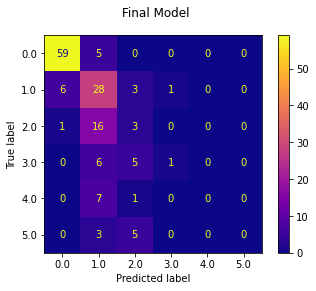

In [247]:
# creating confusion matrix for final model
fig, ax = plt.subplots()

fig.suptitle("Final Model")

plot_confusion_matrix(rf_final, X_test_Scaled, y_test, ax=ax, cmap="plasma");

# Visuals

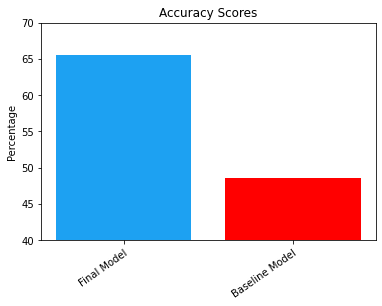

In [6]:
x_acc = ['Final Model', 'Baseline Model']
y_acc = [65.55,48.55]
plt.bar(x = x_acc, height = y_acc, color=['#1DA1F2', 'red'])
plt.xticks(rotation=35, ha="right", rotation_mode='anchor')
plt.ylim([40, 70])
plt.ylabel('Percentage')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title("Accuracy Scores")

plt.savefig('./accurancy_score.png', bbox_inches='tight');

The best score for final model is 65.55% which was a hugh improvement from the score form baseline model(48.55%). The difference is pretty obvious as shown from the graph.

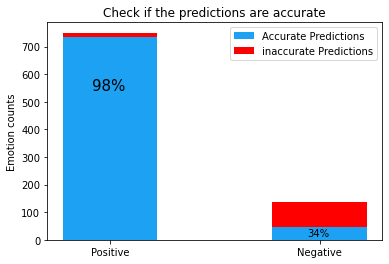

<Figure size 432x288 with 0 Axes>

In [207]:
labels = ['Positive', 'Negative']
co = [ 736, 47]
not_co = [14, 90]
width = 0.45

fig, ax = plt.subplots()

ax.bar(labels, co, width, label='Accurate Predictions', color='#1DA1F2')
ax.bar(labels, not_co, width, bottom=co,
       label='inaccurate Predictions', color='red')

ax.annotate('98%',xy=(45, 150), xycoords='axes pixels', fontsize=15)
ax.annotate('34%',xy=(260, 4), xycoords='axes pixels', fontsize=10)

ax.set_ylabel('Emotion counts')
ax.set_title('Check if the predictions are accurate')
ax.legend()



plt.show();
plt.savefig('./predictions.png', bbox_inches='tight');

The accurate prediction for positive emotion was great, but the model didn’t have a good performance with the negative emotion. The size of the dataset was one big reason for this. There are over 9000 rows for the original dataset but after we drop nans and filter row with only positive and negative emotions, only 3000 rows left. The model could have a better performance with more data points.

# Limitation

For limitation part, there are three major limitations for this project. First is about the time, it just took forever to run some of the model. Secondly, it’s about the incomplete data, there were bunch of null values throughout the entire dataset, and we drop columns with Hugh number of nulls. Finally, according to our research, there are some other features could affect a well more for example the well depth or well maintenance, which not included in dataset.

# Conclusion 

For the conclusion, clean water had become one of the biggest problems in Tanzania, and it’s really necessary to build efficient water points for all type of purposes. Our final model will provide an accurate classifier to predict if the water well would be functional or non-functional. Also find out the  most possible reason that would cause a water well to be non-functional. By implementing our model with professional water institution, there would a higher chance that each water point could run without any issues and save more money for well construction or future repairment and maintenance.

# Next steps

For our next steps, we will try to contact other local water department for more well information and then refine our data. Also we want to contact more foundations like non government organization or maybe International Water Management Institute and show them what we can do with our model. And find a way together to help more African people.